# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [58]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [59]:
url = 'https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv'
df = pd.read_csv(url, encoding='latin-1')
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
1,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
2,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,"As news of the regionÃÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU",Positive
...,...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,"I never that weÃÂd be in a situation &amp; world that going to the supermarket , picking up a package or my mail is like playing Russian roulette with my life #coronavirus #StayHome #SocialDistancing",Positive
33440,44950,89902,NaN,14-04-2020,"@MrSilverScott you are definitely my man. I feel like this fall when we are out and about again, we need to honor our heroes from COVID-19. You know who they are ÃÂ our healthcare people , grocery store owners, and anyone else putting their life on the li",Extremely Positive
33441,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVID-19 related delays. Yet prompt in rejecting policy before consumer TAT is over. Way to go ?,Extremely Negative
33442,44953,89905,NaN,14-04-2020,"You know itÃÂs getting tough when @KameronWilds is rationing toilet paper #coronavirus #toiletpaper @kroger martinsville, help us out!!",Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [60]:
def convert_sentiment(sentiment):
    if sentiment in ['Positive', 'Extremely Positive']:
        return 1
    elif sentiment in ['Negative', 'Extremely Negative']:
        return 0


df['Sentiment'] = df['Sentiment'].apply(convert_sentiment)
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,1
1,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",1
2,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,"As news of the regionÃÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU",1
...,...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,"I never that weÃÂd be in a situation &amp; world that going to the supermarket , picking up a package or my mail is like playing Russian roulette with my life #coronavirus #StayHome #SocialDistancing",1
33440,44950,89902,NaN,14-04-2020,"@MrSilverScott you are definitely my man. I feel like this fall when we are out and about again, we need to honor our heroes from COVID-19. You know who they are ÃÂ our healthcare people , grocery store owners, and anyone else putting their life on the li",1
33441,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVID-19 related delays. Yet prompt in rejecting policy before consumer TAT is over. Way to go ?,0
33442,44953,89905,NaN,14-04-2020,"You know itÃÂs getting tough when @KameronWilds is rationing toilet paper #coronavirus #toiletpaper @kroger martinsville, help us out!!",1


Сбалансированы ли классы?

In [61]:
balance = df['Sentiment'].value_counts()
balance

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:** # классы вполне сбалансированы


Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [62]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Видим пропуски в столбце Location, заполним их

In [63]:
df.fillna('Unknown', inplace=True)
df.isnull().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

На всякий случай проверили, все ли хорошо --- да, можем двигаться дальше

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.3, random_state=0)
print(f'Обучающая выборка: {X_train.shape}, Тестовая выборка: {X_test.shape}')

Обучающая выборка: (23410, 6), Тестовая выборка: (10034, 6)


## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [65]:
from collections import Counter
token_counts = Counter()
for text in X_train['OriginalTweet']:
    tokens = text.lower().split()
    token_counts.update(tokens)
tokens_all = list(token_counts.keys())


Какой размер словаря получился?

In [66]:
print(f'Размер словаря: {len(token_counts)}')


Размер словаря: 79755


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [67]:
top_tokens = token_counts.most_common(10)
for token, freq in top_tokens:
    print(f'{token}: {freq}')


the: 26815
to: 23373
and: 14684
of: 13012
a: 11737
in: 11198
for: 8566
#coronavirus: 8223
is: 7383
are: 7050


**Ответ:** # наиболее часто встречающиеся токены — это стоп-слова (предлоги, союзы и артикли) потому что они являются основой для построения предложений в языке. хЕШТЕГ токен связан (и буквально является) с основной темой твитов, поэтому и находится в топе. Мы не чистили дынные от стоп слов, поэтому и получили такой топ

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [68]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
filtered_token_counts = {token: count for token, count in token_counts.items() if token not in stop_words}
counter = Counter(filtered_token_counts)
top_filtered_tokens = counter.most_common(10)
for token, freq in top_filtered_tokens:
    print(f'{token}: {freq}')

#coronavirus: 8223
prices: 3891
food: 3820
grocery: 3469
supermarket: 3288
people: 3175
covid-19: 3173
store: 3155
#covid19: 2471
&amp;: 2314


**Ответ:**  # стало сильно лучше, однако непонятен последний токен, состоящий из странных символов. А так, он вполне отражает популярные слова и хештеги во время пандемии

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [69]:
least_common_tokens = token_counts.most_common()[:-21:-1]
for token, freq in least_common_tokens:
    print(f'{token}: {freq}')

https://t.co/7j2y3rsld9: 1
@680news: 1
@torontopearson: 1
nothing...: 1
flew: 1
wage!: 1
renewing: 1
playersãâ: 1
subsidise: 1
non-playing: 1
premiership: 1
https://t.co/iaek4fwsgz: 1
@srinivasiyc: 1
https://t.co/zjcl195vqs: 1
#southkerry: 1
#skelligcoast2kms: 1
@skelligsix18: 1
closer!): 1
coast!: 1
skellig: 1


**Ответ:** # в основном здесь наблюдаются отметки каких-то пользователей, вероятно ссылки на профили, слова с опечатками. Так как мы занимаемся определением тональности твитов, стоит убрать редко встречающиеся токены, чтобы сконцентрироваться на более общих и распространенных словах.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [70]:
import warnings
from collections import Counter
import nltk
import pandas as pd
from nltk.tokenize import TweetTokenizer
warnings.filterwarnings("ignore")
nltk.download("punkt", quiet=True)


tw = TweetTokenizer()
X_train['Tokenized'] = X_train['OriginalTweet'].str.lower().apply(tw.tokenize)
all_tokens_tw = sum(X_train['Tokenized'], [])
token_counts_tw = Counter(all_tokens_tw)
top_tokens_tw = token_counts_tw.most_common(10)


for token, freq in top_tokens_tw:
    print(f'{token}: {freq}')

the: 26993
.: 24118
to: 23478
,: 17571
and: 14825
of: 13044
a: 11891
in: 11348
?: 9524
#coronavirus: 8808


**Ответ:** # если говорить в целом про набор токенов (не учитывая появившиеся знаки препинания), то можем увидеть, что частота некоторых слов увеличилась: это может быть связано с тем, что TweetTokenizer более точно разделяет текст на токены, что приводит к увеличению частоты отдельных слов.



Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [71]:
from nltk.corpus import stopwords
import string
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

filtered_tokens_tw = {token: count for token, count in token_counts_tw.items() if token not in stop_words and token not in string.punctuation}
filtered_token_counts_tw = Counter(filtered_tokens_tw)

top_10_filtered_tw = filtered_token_counts_tw.most_common(10)


for token, freq in top_10_filtered_tw:
    print(f'{token}: {freq}')


#coronavirus: 8808
â: 7415
: 7311
19: 7167
covid: 6253
prices: 4601
: 4372
food: 4367
store: 3877
supermarket: 3805


**Ответ:** # ура, появились новые, более значимые токены! Но все еще есть предлоги из других языков и неизвестные символы, которые нам мешают

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [72]:
filtered_tokens_new = {token: count for token, count in filtered_tokens_tw.items() if len(token) > 1 and all(ord(char) < 128 for char in token)}
filtered_token_counts_new = Counter(filtered_tokens_new)
top_10_popular_new = filtered_token_counts_new.most_common(10)
top_20_unpopular_new = filtered_token_counts_new.most_common()[-20:]


print("Топ-10 самых популярных слов:")
for token, freq in top_10_popular_new:
    print(f'{token}: {freq}')


print("\nТоп-20 непопулярных слов:")
for token, freq in top_20_unpopular_new:
    print(f'{token}: {freq}')


Топ-10 самых популярных слов:
#coronavirus: 8808
19: 7167
covid: 6253
prices: 4601
food: 4367
store: 3877
supermarket: 3805
grocery: 3523
people: 3463
#covid19: 2589

Топ-20 непопулярных слов:
https://t.co/pd6ual9yfi: 1
https://t.co/lw1r0rm7xs: 1
https://t.co/5cbliqzx7l: 1
now.when: 1
milion: 1
skellig: 1
@skelligsix18: 1
#skelligcoast2kms: 1
#southkerry: 1
https://t.co/zjcl195vqs: 1
@srinivasiyc: 1
https://t.co/iaek4fwsgz: 1
premiership: 1
non-playing: 1
subsidise: 1
renewing: 1
flew: 1
@torontopearson: 1
@680news: 1
https://t.co/7j2y3rsld9: 1


**Ответ:** # Топ-10 самых популярных слов отражает ключевые темы, связанные с пандемией, что указывает на высокую частоту обсуждения вируса, его последствий, в особенности связанных с продуктами и магазинами. В топ-20 наименее популярных токенах все так же встречаются ссылки, упоминания конкретных аккаунтов, появились числа. В топ-10 теперь слова, действительно содержательные и понятные, наименее популярные теперь без знаков препинаний.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [73]:
hashtags = {token: count for token, count in filtered_tokens_new.items() if token.startswith('#')}
hashtag_counts = Counter(hashtags)
top_10_hashtags = hashtag_counts.most_common(10)
print("Топ-10 популярных хештегов:")
for hashtag, count in top_10_hashtags:
    print(f'{hashtag}: {count}')

Топ-10 популярных хештегов:
#coronavirus: 8808
#covid19: 2589
#covid_19: 1734
#covid2019: 946
#toiletpaper: 744
#covid: 641
#socialdistancing: 465
#coronacrisis: 448
#pandemic: 257
#coronaviruspandemic: 249


**Ответ:** # почти во всех хештегах упоминается covid или что угодно связанное с вирусом, что неудивительно, так как пандемия потрясла весь мир. Забавно, что один из наиболее популярных хештегов --- #toiletpaper, что напоминает нам о панической скупке туалетной бумаги, а также социальная дистанция --- одно из новый правил на следующие несколько лет

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [74]:
links = {token: count for token, count in filtered_tokens_new.items() if token.startswith('https://t.co')}
links_counts = Counter(links)
top_10_links = links_counts.most_common(10)
print("Топ-10 популярных ссылок:")
for link, count in top_10_links:
    print(f'{link}: {count}')

Топ-10 популярных ссылок:
https://t.co/oxa7swtond: 5
https://t.co/gp3eusapl8: 4
https://t.co/wrlhyzizaa: 3
https://t.co/kuwipf1kqw: 3
https://t.co/zjnrx6dkkn: 3
https://t.co/3gbbdpdjat: 3
https://t.co/e2znxajpre: 3
https://t.co/catkegayoy: 3
https://t.co/g63rp042ho: 3
https://t.co/aziqcdgrnn: 3


**Ответ:** # количество упоминаний каждой ссылки не превышает даже 5, относительно размеров нашего датасета это ничтожно мало, так что никакой важной информации они нам не дадут.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [75]:
from string import punctuation
noise = stopwords.words("english") + list(punctuation)

def custom_tokenizer(text):
  tw = TweetTokenizer()
  text = text.lower()
  tokens = [token for token in tw.tokenize(text) if (token not in noise) and not(len(token) == 1 and ord(token) >= 128) and not(token.startswith('https://t.co')) ]
  return tokens


In [76]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(X_train['OriginalTweet'])
print(len(cv.vocabulary_))


45308


**Ответ:** Размер словаря изменился в 2 раза, а значит, мы очистили наши токены достаточно хорошо

Посмотрим на какой-нибудь конкретный твитт:

In [78]:
ind = 9023
X_train.iloc[ind]['OriginalTweet'], X_train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [79]:
cv.fit(X_train['OriginalTweet'])
tweet_vector = cv.transform([X_train.iloc[ind]['OriginalTweet']]).toarray()
max_index = tweet_vector.argmax()
min_value = tweet_vector[tweet_vector > 0].min()
min_index = np.where(tweet_vector == min_value)[1][0]
tokens = cv.get_feature_names_out()
most_important_token = tokens[max_index]
least_important_token = tokens[min_index]
print(f'Самый важный токен: {most_important_token}')
print(f'Самый неважный токен: {least_important_token}')



Самый важный токен: #coronavirusoutbreak
Самый неважный токен: #coronavirusoutbreak


**Ответ:** # не очень хорошо, так как мы получили в обоих случаях одно и то же, что не очень помогает описать тональность твита и его суть


Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(tokenizer=custom_tokenizer)
tf.fit(X_train['OriginalTweet'])
tweet_vector = tf.transform([X_train.iloc[ind]['OriginalTweet']]).toarray()
max_index = tweet_vector.argmax()
min_value = tweet_vector[tweet_vector > 0].min()
min_index = np.where(tweet_vector == min_value)[1][0]
tokens = tf.get_feature_names_out()
most_important_token = tokens[max_index]
least_important_token = tokens[min_index]
print(f'Самый важный токен: {most_important_token}')
print(f'Самый неважный токен: {least_important_token}')

Самый важный токен: brainless
Самый неважный токен: food


**Ответ:** # теперь токены определились достаточн хорошо, так как самый важный токен в целом отображает суть твита и по нему достаточно просто определить, что твит негативный

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [81]:
X_train[X_train['OriginalTweet'].apply(lambda x: 'cool' in x) & (X_train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tokenized
11966,18316,63268,Unknown,21-03-2020,I said thank you to grocery store clerks before it was cool ?????\r\r\n#Covid_19,1,"[i, said, thank, you, to, grocery, store, clerks, before, it, was, cool, ?, ?, ?, #covid_19]"
5973,11052,56004,"Brooklyn, NY",19-03-2020,"This was a tough one to write given the #pandemic weÃÂre currently facing. Though as a #marketing nerd, there are super cool insights to take in given the shifts the #coronavirus is having on consumer behavior and media consumption https://t.co/mbpKHHJ3os",1,"[this, was, a, tough, one, to, write, given, the, #pandemic, weã, , â, , re, currently, facing, ., though, as, a, #marketing, nerd, ,, there, are, super, cool, insights, to, take, in, given, the, shifts, the, #coronavirus, is, having, on, consumer, behavior, and, media, consumption, https://t.co/mbpkhhj3os]"
7138,12468,57420,Earth,20-03-2020,@DrSundara3 Most probably in cool air conditioned environment. Follow the equator.\r\r\nhttps://t.co/zu2fCHMEyn If so even icu could be a conducive environment and the only solution is alcohol sprays. Supply large quantities to every street for decontaminati,1,"[@drsundara3, most, probably, in, cool, air, conditioned, environment, ., follow, the, equator, ., https://t.co/zu2fchmeyn, if, so, even, icu, could, be, a, conducive, environment, and, the, only, solution, is, alcohol, sprays, ., supply, large, quantities, to, every, street, for, decontaminati]"
30611,41445,86397,"Yorkshire, UK; Pasifika; et al",10-04-2020,@nicolasnicola22 @ChunhuaMs @Aussieneets @RussellMoxham @debbie_spirit @griffjane @orangulandtrust @orangutans @WildlingRocks @Ness4612R @samcoyi @DrBirute @coolrunning2009 @BlueSeas111 @RedFoxGIS @EmilyLe89720714 @orangutan2 @RedOrangutangen @ForestPeopl,1,"[@nicolasnicola22, @chunhuams, @aussieneets, @russellmoxham, @debbie_spirit, @griffjane, @orangulandtrust, @orangutans, @wildlingrocks, @ness4612r, @samcoyi, @drbirute, @coolrunning2009, @blueseas111, @redfoxgis, @emilyle89720714, @orangutan2, @redorangutangen, @forestpeopl]"
22029,30695,75647,Mumbai,02-04-2020,"#NewsUpdate | Australian #home prices extended gains in March, although conditions are expected to cool as #coronavirus pandemic causes widespread economic disruption and hits household confidence\r\r\n\r\r\n#australia #realestate #property #RealEstateNews #realty\r\r\nhttps://t.co/kZrBLP7o7W",1,"[#newsupdate, |, australian, #home, prices, extended, gains, in, march, ,, although, conditions, are, expected, to, cool, as, #coronavirus, pandemic, causes, widespread, economic, disruption, and, hits, household, confidence, #australia, #realestate, #property, #realestatenews, #realty, https://t.co/kzrblp7o7w]"
18398,26181,71133,"Long Beach, CA",25-03-2020,A cool site that shows consumer behavior trends since COVID-19 https://t.co/7YuAhgRxz0,1,"[a, cool, site, that, shows, consumer, behavior, trends, since, covid, -, 19, https://t.co/7yuahgrxz0]"
29239,39679,84631,Unknown,09-04-2020,Very cool to see the Muddy River Distillery manufacturing hand sanitizer for first responders I am thankful for the many ways the community is supporting one another in our fight against the,1,"[very, cool, to, see, the, muddy, river, distillery, manufacturing, hand, sanitizer, for, first, responders, i, am, thankful, for, the, many, ways, the, community, is, supporting, one, another, in, our, fight, against, the]"
22101,30793,75745,"Bad, Wildbad",02-04-2020,"The little neighbourhood I live in is culturally vibrant - just dense with cool shops, markets, and restaurants. A lot of them are closed now and I wonder what percentage will open post #coronavirus.\r\r\n\r\r\nTruly regret just going to my closest Starbucks and supermarket all the time.",1,"[the, little, neighbourhood, i, live, in, is, culturally, vibrant, -, just, dense, with, cool, shops, ,, markets, ,, and, restaurants, ., a, lot, of, them, are, closed, now, and, i, wonder, what, percentage, will, open, 

In [82]:
v = 71133
row = X_train.query('ScreenName == @v')
tweet_text = row['OriginalTweet']
tweet_vector = tf.transform(tweet_text).toarray()
max_index = tweet_vector.argmax()
min_value = tweet_vector[tweet_vector > 0].min()
min_index = np.where(tweet_vector == min_value)[1][0]
tokens = tf.get_feature_names_out()
most_important_token = tokens[max_index]
least_important_token = tokens[min_index]
print(f'Самый важный токен: {most_important_token}')
print(f'Самый неважный токен: {least_important_token}')
pd.set_option('display.max_colwidth', None)


with pd.option_context('display.max_colwidth', None):
    print(row['OriginalTweet'])

Самый важный токен: cool
Самый неважный токен: 19
18398    A cool site that shows consumer behavior trends since COVID-19 https://t.co/7YuAhgRxz0
Name: OriginalTweet, dtype: object


**Ответ:** # слово cool является в данном случае положительным прилагательным, что и помогает оценить этоот твит как положительный

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [83]:

cv = CountVectorizer(tokenizer=custom_tokenizer)
tf = TfidfVectorizer(tokenizer=custom_tokenizer)
texts_train = X_train['OriginalTweet']
target_train = X_train['Sentiment']
count_matrix_train = cv.fit_transform(texts_train)
tfidf_matrix_train = tf.fit_transform(texts_train)

texts_test = X_test['OriginalTweet']
target_test = X_test['Sentiment']
count_matrix_test = cv.transform(texts_test)
tfidf_matrix_test = tf.transform(texts_test)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
log_reg_cv = LogisticRegression()
log_reg_cv.fit(count_matrix_train, target_train)
train_preds_cv = log_reg_cv.predict(count_matrix_train)
train_accuracy_cv = accuracy_score(target_train, train_preds_cv)
test_preds_cv = log_reg_cv.predict(count_matrix_test)
test_accuracy_cv = accuracy_score(target_test, test_preds_cv)


log_reg_tf = LogisticRegression()
log_reg_tf.fit(tfidf_matrix_train, target_train)
train_preds_tf = log_reg_tf.predict(tfidf_matrix_train)
train_accuracy_tf = accuracy_score(target_train, train_preds_tf)
test_preds_tf = log_reg_tf.predict(tfidf_matrix_test)
test_accuracy_tf = accuracy_score(target_test, test_preds_tf)

print(f'CountVectorizer - Train Accuracy: {train_accuracy_cv:.4f}, Test Accuracy: {test_accuracy_cv:.4f}')
print(f'TfidfVectorizer - Train Accuracy: {train_accuracy_tf:.4f}, Test Accuracy: {test_accuracy_tf:.4f}')


CountVectorizer - Train Accuracy: 0.9845, Test Accuracy: 0.8675
TfidfVectorizer - Train Accuracy: 0.9255, Test Accuracy: 0.8534


**Ответ:** # CountVectorizer дал несколько лучший результат, чем TfidfVectorizer. Однако разница в целом не сильно большая. Возможно CountVectorizer слегка переобучился тк разница с тестом 10%, у TfidfVectorizer эта разница меньше


## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [85]:
from nltk.stem.snowball import SnowballStemmer
import re
stemmer = SnowballStemmer("english")

def custom_stem_tokenizer(text):
  tw = TweetTokenizer()
  text = text.lower()
  tokens = [token for token in tw.tokenize(text) if (token not in noise) and not(len(token) == 1 and ord(token) >= 128) and not(token.startswith('https://t.co')) ]
  stemmed_tokens = [stemmer.stem(token) for token in tokens]
  return stemmed_tokens

In [86]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [87]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
tf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

cv.fit(X_train['OriginalTweet'])
tf.fit(X_train['OriginalTweet'])

print(f'Размер словаря CountVectorizer после стемминга: {len(cv.vocabulary_)}')




Размер словаря CountVectorizer после стемминга: 36652


**Ответ** # словарь уменьшился примерно на 10 тысяч, что довольно хорошо сократило количество токенов

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [88]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
tf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
texts_train = X_train['OriginalTweet']
target_train = X_train['Sentiment']
count_matrix_train = cv.fit_transform(texts_train)
tfidf_matrix_train = tf.fit_transform(texts_train)

texts_test = X_test['OriginalTweet']
target_test = X_test['Sentiment']
count_matrix_test = cv.transform(texts_test)
tfidf_matrix_test = tf.transform(texts_test)

log_reg_cv = LogisticRegression()
log_reg_cv.fit(count_matrix_train, target_train)
train_preds_cv = log_reg_cv.predict(count_matrix_train)
train_accuracy_cv = accuracy_score(target_train, train_preds_cv)
test_preds_cv = log_reg_cv.predict(count_matrix_test)
test_accuracy_cv = accuracy_score(target_test, test_preds_cv)


log_reg_tf = LogisticRegression()
log_reg_tf.fit(tfidf_matrix_train, target_train)
train_preds_tf = log_reg_tf.predict(tfidf_matrix_train)
train_accuracy_tf = accuracy_score(target_train, train_preds_tf)
test_preds_tf = log_reg_tf.predict(tfidf_matrix_test)
test_accuracy_tf = accuracy_score(target_test, test_preds_tf)

print(f'CountVectorizer - Train Accuracy: {train_accuracy_cv:.4f}, Test Accuracy: {test_accuracy_cv:.4f}')
print(f'TfidfVectorizer - Train Accuracy: {train_accuracy_tf:.4f}, Test Accuracy: {test_accuracy_tf:.4f}')

CountVectorizer - Train Accuracy: 0.9718, Test Accuracy: 0.8675
TfidfVectorizer - Train Accuracy: 0.9159, Test Accuracy: 0.8561


**Ответ:** # немного уменьшилось переобучение на countvectorizer, но глобально результаты не изменились, поэтому как будто стемминг бесполезен здесь

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [89]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=0.3).fit(X_train['OriginalTweet'])
print(len(cv_df.vocabulary_))

36651


**Ответ:** # 30% кажется довольно большим числом, но это неудивительно, ведь все наши твиты связаны единой темой --- пандемией, поэтому ее упоминание в текстах будет довольно частым, но при этом не поможет определить тональность

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [90]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.00045).fit(X_train['OriginalTweet'])
print(len(cv_df.vocabulary_))

3700


In [91]:
count_matrix_train = cv_df.fit_transform(texts_train)


count_matrix_test = cv_df.transform(texts_test)


log_reg_cv = LogisticRegression()
log_reg_cv.fit(count_matrix_train, target_train)
train_preds_cv = log_reg_cv.predict(count_matrix_train)
train_accuracy_cv = accuracy_score(target_train, train_preds_cv)
test_preds_cv = log_reg_cv.predict(count_matrix_test)
test_accuracy_cv = accuracy_score(target_test, test_preds_cv)


print(f'CountVectorizer - Train Accuracy: {train_accuracy_cv:.4f}, Test Accuracy: {test_accuracy_cv:.4f}')


CountVectorizer - Train Accuracy: 0.9284, Test Accuracy: 0.8677


**Ответ:** # уменьшилось переобучение, в целом, все выглядит достаточно хорошо, качество не пострадало

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

Точность модели: 0.8447
['#ccp' '#dortmund' '#ferret' '#crazytimesã' '#cdc' '#freemarket'
 '#cornavirusoutbreak' '#co2' '#healthcar' '#coronaalert']


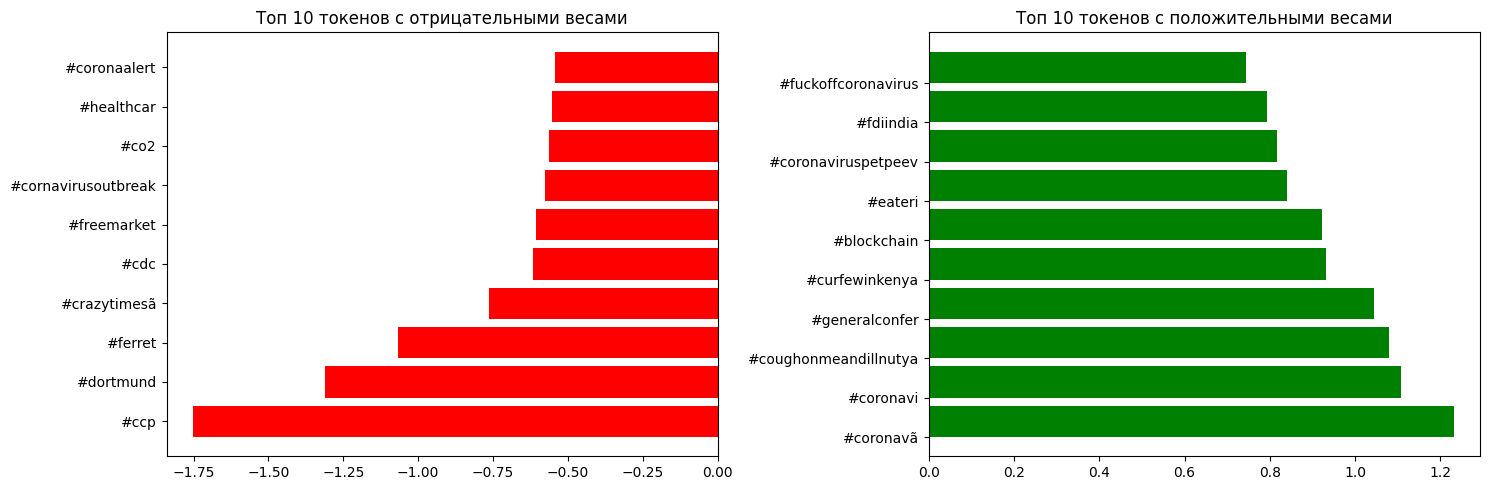

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    cv_df,
    StandardScaler(with_mean=False),
    LogisticRegression()
)

pipeline.fit(texts_train, target_train)
y_pred = pipeline.predict(texts_test)
print(f'Точность модели: {accuracy_score(target_test, y_pred):.4f}')

model = pipeline.named_steps['logisticregression']
feature_names = cv.get_feature_names_out()
coefs = model.coef_[0]

top_positive_tokens = np.argsort(coefs)[-10:]
top_negative_tokens = np.argsort(coefs)[:10]



plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 2)
plt.barh(range(10,0,-1), coefs[top_positive_tokens], color='green', align='edge')
plt.yticks(range(10,0,-1), np.array(feature_names)[top_positive_tokens], ha='right')
plt.title('Топ 10 токенов с положительными весами')

plt.subplot(1, 2, 1)
plt.barh(range(10), coefs[top_negative_tokens], color='red')
plt.yticks(range(10), np.array(feature_names)[top_negative_tokens])
plt.title('Топ 10 токенов с отрицательными весами')
print(np.array(feature_names)[top_negative_tokens])
plt.tight_layout()
plt.show()

**Ответ:** # все токены являются хештегами, это вполне объяснимо, так как хештеги объединяют твиты одной темы. при этом токены с положительным весом предполагают положительную окраску текста, так как #coronaviruspetpeev и #coughonmeandillnutya могут отражать ироничное или шутливое отношение к ситуации, например. А вот #ccp может отражать критику в адрес партии Китая в контексте пандемии, #healthcar и #coronaalert могут быть связаны с проблемами здравоохранения и предупреждениями о коронавирусе. (пришлось погуглить хештеги)

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

**Ответ:** # полагаю, что эти признаки не дадут нам достаточное количество полезной информации, так как username --- по сути id пользователя и помогает только объединить твиты от одного пользователя. screenname что-то вроде id для твита, так что вероятно тоже ничего не даст. Связи с айдишниками обычно нет)))

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

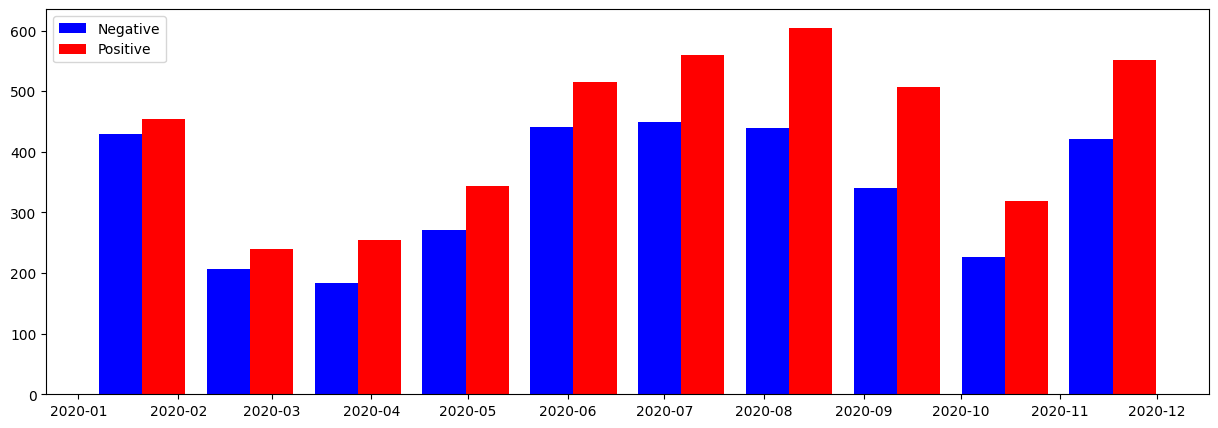

In [93]:
X_train['TweetAt'] = pd.to_datetime(X_train['TweetAt'],errors='coerce')
X_test['TweetAt'] = pd.to_datetime(X_test['TweetAt'],errors='coerce')
plt.figure(figsize=(15, 5))
plt.hist([X_train[target_train == 0]['TweetAt'], X_train[target_train == 1]['TweetAt']], color=['blue', 'red'], label=['Negative', 'Positive'])
plt.legend()
plt.show()

**Ответ:** # в целом, корреляция есть, но не супер сильная, поэтому дата твита не особо полезна для определения его окраски



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [94]:
unique_locations = X_train['Location'].nunique()
print(f'Количество уникальных значений в столбце Location: {unique_locations}')

Количество уникальных значений в столбце Location: 7949


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

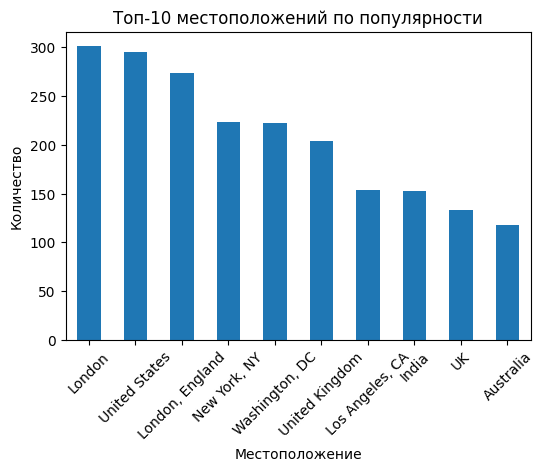

In [95]:
filtered_locations = X_train[X_train['Location'] != 'Unknown']


location_counts = filtered_locations['Location'].value_counts().head(10)


plt.figure(figsize=(6, 4))
location_counts.plot(kind='bar')
plt.title('Топ-10 местоположений по популярности')
plt.xlabel('Местоположение')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

Количество уникальных категорий: 4766


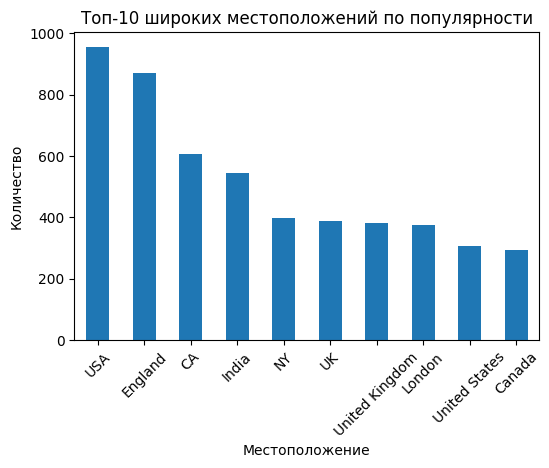

In [108]:
def extract_wider_location(location):
    if ',' in location:
        return location.split(',')[-1].strip()
    return location

X_train['WiderLocation'] = X_train['Location'].apply(extract_wider_location)
X_test['WiderLocation'] = X_test['Location'].apply(extract_wider_location)

unique_categories_count = X_train['WiderLocation'].nunique()
print(f'Количество уникальных категорий: {unique_categories_count}')


filtered_wider_locations = X_train[X_train['WiderLocation'] != 'Unknown']
filtered_wider_locations_test = X_test[X_test['WiderLocation'] != 'Unknown']
wider_location_counts = filtered_wider_locations['WiderLocation'].value_counts().head(10)
wider_location_counts_test = filtered_wider_locations_test['WiderLocation'].value_counts().head(10)

plt.figure(figsize=(6, 4))
wider_location_counts.plot(kind='bar')
plt.title('Топ-10 широких местоположений по популярности')
plt.xlabel('Местоположение')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [109]:
location_counts = X_train['WiderLocation'].value_counts()
locations_more_than_once = location_counts[location_counts > 1].index

location_counts_test = X_test['WiderLocation'].value_counts()
locations_more_than_once_test = location_counts_test[location_counts_test > 1].index

df_ohe = pd.get_dummies(X_train['WiderLocation'])
df_ohe = df_ohe[locations_more_than_once]

df_ohe_test = pd.get_dummies(X_test['WiderLocation'])
df_ohe_test = df_ohe_test[locations_more_than_once_test]

num_of_ohe_features = df_ohe.shape[1]
print(f'Количество признаков после OHE: {num_of_ohe_features}')

Количество признаков после OHE: 1005


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [110]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

X_train_counts = cv_df.fit_transform(texts_train)

X_test_counts = cv_df.transform(texts_test)

df_ohe = ohe.fit_transform(X_train[['WiderLocation']])

df_ohe_test = ohe.transform(X_test[['WiderLocation']])


X_train_combined = hstack([X_train_counts, df_ohe])
X_test_combined = hstack([X_test_counts, df_ohe_test])


pipeline = Pipeline([

    ('logreg', LogisticRegression())
])


pipeline.fit(X_train_combined, target_train)


y_pred = pipeline.predict(X_test_combined)


accuracy = accuracy_score(target_test, y_pred)
print(f'Точность модели: {accuracy:.4f}')

Точность модели: 0.8657


**Ответ:** # качество особо не изменилось, даже упало, поэтому признак оказался бесполезным ):

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

**ПАЦИЕНТ МЕРТВ**